# RAG - ColBERT IR, gpt tubo 3.5

## IR

### 라이브러리 설치 및 임포트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch==2.4.1 # 런타임 재시작 후 재실행

In [3]:
!pip install torchaudio torchvision --upgrade


In [4]:
# OpenAI Python 패키지 설치
!pip install openai

# 검색엔진을 위해 ColBERT 사용
!pip install "colbert-ir[faiss-gpu, torch]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 M

In [5]:
# 필요한 라이브러리 import

from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection
import colbert
import json

In [6]:
# from transformers import AutoTokenizer
# from collections import Counter

# # colbertv2.0 토크나이저 로드
# tokenizer = AutoTokenizer.from_pretrained('colbert-ir/colbertv2.0')

# # JSONL 파일 경로
# file_path = '/content/drive/MyDrive/colbert_ir/documents.jsonl'

# # 토큰 수를 저장할 리스트
# token_counts = []

# # JSONL 파일 읽기
# with open(file_path, 'r', encoding='utf-8') as file:
#     for line in file:
#         data = json.loads(line)
#         content = data.get('content', '')
#         tokens = tokenizer.tokenize(content)
#         token_counts.append(len(tokens))

# # 평균 토큰 수, 최고 토큰 수 및 최빈 토큰 수 계산
# average_token_count = sum(token_counts) / len(token_counts) if token_counts else 0
# max_token_count = max(token_counts) if token_counts else 0
# most_common_token_count = Counter(token_counts).most_common(1)[0][0] if token_counts else 0

# print(f"평균 토큰 수: {average_token_count}")
# print(f"최고 토큰 수: {max_token_count}")
# print(f"최빈 토큰 수: {most_common_token_count}")




평균 토큰 수: 450.43422284644197

최고 토큰 수: 1850

최빈 토큰 수: 419

In [7]:
# from transformers import AutoTokenizer
# import json
# import matplotlib.pyplot as plt

# # colbertv2.0 토크나이저 로드
# tokenizer = AutoTokenizer.from_pretrained('colbert-ir/colbertv2.0')

# # JSONL 파일 경로
# file_path = '/content/drive/MyDrive/colbert_ir/documents.jsonl'

# # 토큰 수를 저장할 리스트
# token_counts = []

# # JSONL 파일 읽기
# with open(file_path, 'r', encoding='utf-8') as file:
#     for line in file:
#         data = json.loads(line)
#         content = data.get('content', '')
#         tokens = tokenizer.tokenize(content)
#         token_counts.append(len(tokens))

# # 토큰 길이의 산점도 시각화
# plt.figure(figsize=(12, 6))
# plt.scatter(range(len(token_counts)), token_counts, alpha=0.6)
# plt.title('Token Length Distribution per Sentence')
# plt.xlabel('Sentence Index')
# plt.ylabel('Token Length')
# plt.grid(True)
# plt.show()


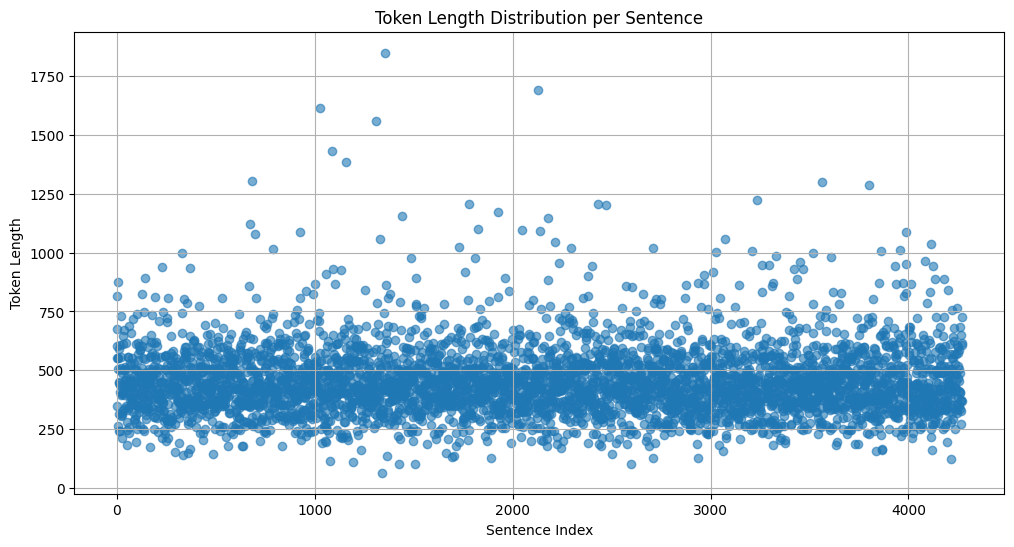

In [8]:
# from transformers import AutoTokenizer
# import json
# import matplotlib.pyplot as plt
# import numpy as np

# # colbertv2.0 토크나이저 로드
# tokenizer = AutoTokenizer.from_pretrained('colbert-ir/colbertv2.0')

# # JSONL 파일 경로
# file_path = '/content/drive/MyDrive/colbert_ir/documents.jsonl'

# # 토큰 수를 저장할 리스트
# token_counts = []

# # JSONL 파일 읽기
# with open(file_path, 'r', encoding='utf-8') as file:
#     for line in file:
#         data = json.loads(line)
#         content = data.get('content', '')
#         tokens = tokenizer.tokenize(content)
#         token_counts.append(len(tokens))

# # IQR 및 사분위수 계산
# Q1 = np.percentile(token_counts, 25)
# Q2 = np.median(token_counts)
# Q3 = np.percentile(token_counts, 75)
# Q4 = np.percentile(token_counts, 100)
# IQR = Q3 - Q1

# print(f"1사분위수 (Q1): {Q1}")
# print(f"중앙값 (Q2): {Q2}")
# print(f"3사분위수 (Q3): {Q3}")
# print(f"IQR: {IQR}")

# # 상자 그림(Box Plot) 시각화
# plt.figure(figsize=(8, 6))
# plt.boxplot(token_counts, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='lightblue'))
# plt.title('Token Length Distribution - Box Plot')
# plt.xlabel('Token Length')
# plt.grid(True)
# plt.show()




1사분위수 (Q1): 358.0

중앙값 (Q2): 431.0

3사분위수 (Q3): 518.0

IQR: 160.0

Upper_bound = Q3 + 1.5 * IQR : 758.0

전체 문장 개수 : 4272

상한 경계 초과 : 142

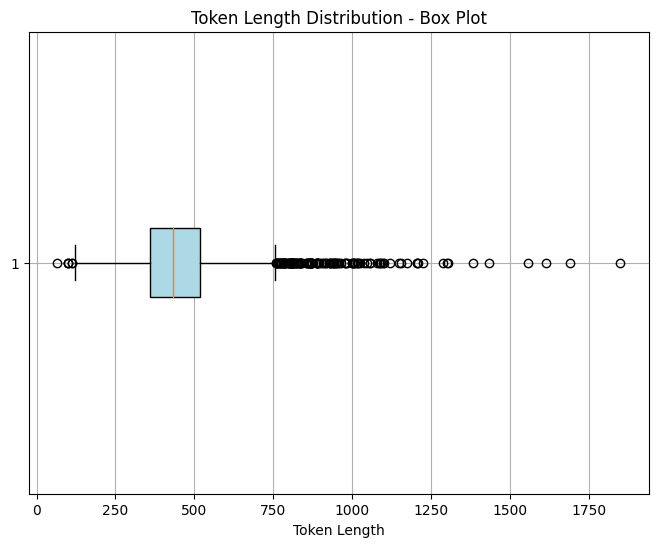

In [9]:
# from transformers import AutoTokenizer
# import json
# import matplotlib.pyplot as plt
# import numpy as np

# # colbertv2.0 토크나이저 로드
# tokenizer = AutoTokenizer.from_pretrained('colbert-ir/colbertv2.0')

# # JSONL 파일 경로
# file_path = '/content/drive/MyDrive/colbert_ir/eval.jsonl'

# # 토큰 수를 저장할 리스트
# token_counts = []

# # JSONL 파일 읽기
# with open(file_path, 'r', encoding='utf-8') as file:
#     for line in file:
#         data = json.loads(line)
#         # "msg" 필드에서 "content" 값 추출
#         messages = data.get('msg', [])
#         for message in messages:
#             content = message.get('content', '')
#             tokens = tokenizer.tokenize(content)
#             token_counts.append(len(tokens))

# # IQR 및 사분위수 계산
# Q1 = np.percentile(token_counts, 25)
# Q2 = np.median(token_counts)
# Q3 = np.percentile(token_counts, 75)
# IQR = Q3 - Q1

# print(f"1사분위수 (Q1): {Q1}")
# print(f"중앙값 (Q2): {Q2}")
# print(f"3사분위수 (Q3): {Q3}")
# print(f"IQR: {IQR}")

# # 상자 그림(Box Plot) 시각화
# plt.figure(figsize=(8, 6))
# plt.boxplot(token_counts, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='lightblue'))
# plt.title('Token Length Distribution - Box Plot')
# plt.xlabel('Token Length')
# plt.grid(True)
# plt.show()

# Upper_bound = Q3 + 1.5 * IQR # 상한경계
# print("Upper_bound : ",Upper_bound)
# upper_counts = (token_counts>=Upper_bound).sum()
# print(upper_counts) # 상한경계 초과하는 이상치 데이터 개수


In [10]:
# average_token_count = sum(token_counts) / len(token_counts)
# print(average_token_count)
# # 평균 : 33.45

1사분위수 (Q1): 23.75

중앙값 (Q2): 32.0

3사분위수 (Q3): 42.0

IQR: 18.25

Upper_bound = Q3 + 1.5 * IQR : 69.375

전체 문장 개수 : 220

상한 경계 초과 : 4

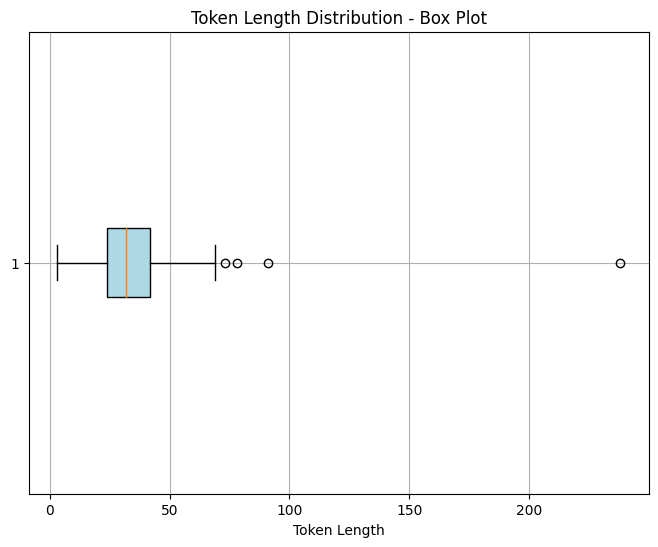

### ColBER 색인

In [11]:
import torch
print(torch.cuda.is_available())  # True여야 합니다.
print(torch.cuda.get_device_name(0))  # 'Tesla T4'와 같은 GPU 이름이 나와야 합니다.


True
Tesla T4


In [12]:
import torch
print(torch.cuda.is_available())  # True가 출력되면 GPU 사용이 가능함을 의미합니다.
print(torch.cuda.device_count())  # 사용 가능한 GPU의 수를 출력합니다.


True
1


In [13]:
# 문서 파일 경로 및 로드
input_file_path = '/content/drive/MyDrive/colbert_ir/documents.jsonl'
collection = []
docid_list = []
src_list = []

# JSONL 파일에서 문서 데이터를 로드하여 리스트로 저장
with open(input_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        document = json.loads(line.strip())
        collection.append(document['content'])  # 'content' 필드만 사용하여 색인
        docid_list.append(document['docid'])
        src_list.append(document['src'])

In [14]:
# 색인 생성 설정
checkpoint = 'colbert-ir/colbertv2.0' # 'colbert-ir/colbertv2.0' # jgkym/ko-colbert-v2-fis
index_name = "test"
doc_maxlen = 450  # 문서의 최대 길이 설정 (gpu사용을 하지 않음....ㅜㅜ왜지...)
query_mexlen = 70

# 색인 생성
with Run().context(RunConfig(nranks=1, experiment='notebook')):  # nranks는 사용할 GPU의 수를 지정합니다.
    # ColBERT의 설정을 초기화합니다.
    config = ColBERTConfig(
        doc_maxlen=doc_maxlen,  # 문서의 최대 길이를 지정합니다.
        nbits=2,  # 양자화에 사용되는 비트 수를 설정합니다. 일반적으로 작은 값일수록 인덱스가 더 작아집니다.
        kmeans_niters=4,  # k-means 클러스터링의 반복 횟수를 지정합니다. 4는 빠르고 기본적으로 좋은 값입니다. 작은 데이터셋일 경우 더 큰 값을 고려할 수 있습니다.
        query_maxlen=query_mexlen, # 쿼리의 최대 길이 (기본값: 32) 쿼리 텍스트의 최대 토큰 길이를 설정합니다.
        bsize=4,
        reranker=True # 디폴트는 False
        # amp=True  # GPU 사용을 명시적으로 활성화(혼합 정밀도 학습을 활성화)
    )

                                                                            # 데이터셋이 작은 경우 더 큰 값을 고려하십시오.
    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection, overwrite=True)  # 'max_id' 부분 삭제






[Oct 11, 14:19:24] #> Creating directory /content/experiments/notebook/indexes/test 


#> Starting...
#> Joined...


#### ColBERTConfig 클래스 파라미터 설명
- query_token_id: 쿼리 토큰에 사용할 토큰 ID (기본값: "[unused0]")

  - 쿼리 텍스트의 시작을 나타내는 토큰 ID입니다. 기본값은 "[unused0]"로, 사전 훈련된 모델의 사용되지 않는 토큰을 활용합니다.
- doc_token_id: 문서 토큰에 사용할 토큰 ID (기본값: "[unused1]")

  - 문서 텍스트의 시작을 나타내는 토큰 ID입니다. 기본값은 "[unused1]"입니다.
- query_token: 쿼리 텍스트에서 사용할 실제 토큰 문자열 (기본값: "[Q]")

  - 쿼리와 문서를 구분하기 위해 사용되는 문자열 토큰입니다.
- doc_token: 문서 텍스트에서 사용할 실제 토큰 문자열 (기본값: "[D]")

  - 문서와 쿼리를 구분하기 위해 사용되는 문자열 토큰입니다.
- ncells: 인덱스에서 사용할 셀(cell)의 수 (기본값: None)

  - 인덱스의 세분화 수준을 결정하는 매개변수로, 값이 클수록 인덱스의 세분화가 증가합니다.
- centroid_score_threshold: 중심 점수 임계값 (기본값: None)

  - 인덱싱 중 중심 점수가 이 값보다 낮으면 해당 셀을 필터링합니다.
- ndocs: 처리할 문서의 수 (기본값: None)

  - 데이터셋에서 처리할 문서의 최대 개수를 설정합니다. 매우 큰 데이터셋에서 일부만 사용할 때 유용합니다.
- load_index_with_mmap: 메모리 매핑으로 인덱스를 로드할지 여부 (기본값: False)

  - 메모리 사용량 최적화를 위해 인덱스를 메모리 매핑 파일로 로드할지 결정합니다.
- index_path: 인덱스를 저장하거나 불러올 파일 경로 (기본값: None)

  - 인덱스를 저장하거나 불러오는 데 사용할 파일 경로입니다.
- nbits: 인덱스 압축 시 사용할 비트 수 (기본값: 1)

  - 인덱스 벡터를 압축할 때 사용하는 비트 수입니다. 낮은 비트 수는 메모리를 절약하지만 정확도를 낮출 수 있습니다.
- kmeans_niters: K-평균 반복 횟수 (기본값: 4)

  - K-평균 클러스터링 알고리즘을 수행할 반복 횟수입니다.
- resume: 학습 재개 여부 (기본값: False)

  - 이전 체크포인트에서 학습을 이어서 할지 여부를 나타냅니다.
- similarity: 유사도 측정 방식 (기본값: 'cosine')

  - 벡터 간 유사도를 계산할 때 사용할 방법입니다. cosine 또는 inner product가 일반적으로 사용됩니다.
- bsize: 배치 크기 (기본값: 32)

  - 한 번에 처리할 데이터 샘플의 개수를 나타냅니다.
- accumsteps: 그래디언트 누적 단계 수 (기본값: 1)

  - 그래디언트를 업데이트하기 전에 몇 번의 배치를 누적할지 지정합니다.
- lr: 학습률 (기본값: 0.000003)

  - 모델 학습 시 가중치가 얼마나 빠르게 조정되는지를 결정하는 하이퍼파라미터입니다.
- maxsteps: 최대 학습 단계 수 (기본값: 500000)

  - 지정된 단계 수에 도달하면 학습이 종료됩니다.
- save_every: 모델 저장 간격 (기본값: None)

  - 일정한 단계마다 모델 체크포인트를 저장하도록 설정합니다.
- warmup: 학습 초기화 단계 수 (기본값: None)

  - 학습 초기에 학습률을 점진적으로 증가시키는 단계 수입니다.
- warmup_bert: BERT 학습 초기화 단계 수 (기본값: None)

  - BERT 모델을 위한 별도의 워밍업 단계 수를 설정합니다.
- relu: ReLU 활성화 함수 사용 여부 (기본값: False)

  - ReLU 활성화 함수를 사용할지 여부를 결정합니다.
- nway: n-way 분류 클래스 수 (기본값: 2)

  - 다중 클래스 분류 문제에서의 클래스 수입니다.
- use_ib_negatives: In-Batch 네거티브 샘플 사용 여부 (기본값: False)

  - 학습 시 부정 예시(negative samples)를 포함하여 모델의 정밀도를 향상시킵니다.
- reranker: 재순위 지정 사용 여부 (기본값: False)

  - 초기 검색 결과를 재정렬하기 위해 재순위 모델을 사용할지 여부를 설정합니다.
- distillation_alpha: 모델 증류 알파 값 (기본값: 1)

  - 교사 모델과 학생 모델 간의 로스를 조절하는 파라미터입니다.
- ignore_scores: 점수 무시 여부 (기본값: False)

  - 검색 결과의 점수를 무시할지 여부를 설정합니다.
- model_name: 모델 이름 (기본값: None)

  - 사용할 사전 훈련된 모델의 이름을 지정합니다.
- query_maxlen: 쿼리의 최대 길이 (기본값: 32)
  
  - 쿼리 텍스트의 최대 토큰 길이를 설정합니다.
- attend_to_mask_tokens: 마스크 토큰에 집중 여부 (기본값: False)

  - 모델이 마스크 토큰에 집중할지 여부를 결정합니다.
- interaction: 상호작용 방식 (기본값: 'colbert')

  - 모델 간 상호작용 방식을 설정합니다.
- dim: 임베딩 차원 (기본값: 128)

  - 벡터 임베딩의 차원 수입니다. 높은 차원은 더 정밀한 표현을 제공합니다.
- doc_maxlen: 문서의 최대 길이 (기본값: 220)

  - 문서 텍스트의 최대 토큰 길이를 설정합니다.
- mask_punctuation: 구두점 마스킹 여부 (기본값: True)

  - 구두점을 마스킹하여 모델 학습에서 무시할지 여부를 설정합니다.
- checkpoint: 체크포인트 경로 (기본값: None)

  - 학습 중간에 저장된 모델의 체크포인트 파일 경로입니다.
- triples: 트리플 데이터셋 경로 (기본값: None)

  - 학습에 사용할 질문, 긍정 문서, 부정 문서로 구성된 트리플 데이터셋의 경로입니다.
- collection: 컬렉션 데이터 경로 (기본값: None)

  - 문서 데이터의 경로입니다.
- queries: 쿼리 데이터 경로 (기본값: None)

  - 쿼리 데이터셋의 파일 경로입니다.
- index_name: 인덱스 이름 (기본값: None)

  - 인덱스를 저장하거나 불러올 때 사용할 이름입니다.
- overwrite: 기존 설정 덮어쓰기 여부 (기본값: False)

  - 기존 인덱스나 파일을 덮어쓸지 여부를 결정합니다.
- root: 실험 루트 경로 (기본값: 현재 작업 디렉토리의 'experiments')

  - 실험 데이터를 저장할 기본 경로입니다.
- experiment: 실험 이름 (기본값: 'default')

  - 실험의 이름을 지정하여 여러 실험을 구분합니다.
- index_root: 인덱스 파일 경로 (기본값: None)

  - 인덱스 파일을 저장할 기본 경로입니다.
- name: 실험 고유 이름 (기본값: 타임스탬프 기반)

  - 실험의 고유 식별자입니다.
- rank: 프로세스 순위 (기본값: 0)

  - 분산 학습에서 프로세스의 순위를 나타냅니다.
- nranks: 총 프로세스 수 (기본값: 1)

  - 분산 학습에서 사용할 프로세스의 총 개수입니다.
- amp: 자동 혼합 정밀도 사용 여부 (기본값: True)

  - 자동 혼합 정밀도를 사용하여 학습 속도와 메모리 효율성을 향상시킬지 결정합니다.
- gpus: 사용 가능한 GPU 수 (기본값: 시스템에서 감지된 GPU 수)

  - 학습에 사용할 GPU의 수를 설정합니다.

In [ ]:
# collection[0]
# 태양과 달이 대략 같은 크기로 보이는 이유는 달이 태양보다 지름이 더 짧고 지구에서 더 가까이 위치하기 때문입니다. 달은 지구와의 거리가 상대적으로 가까워서 우리 눈에는 태양과 달이 비슷한 크기로 보입니다. 이는 우연이 아니라 천문학적인 현상으로, 이러한 현상을 '달의 지름 효과'라고 합니다. 태양과 달이 대략 같은 크기로 보이는 이러한 현상은 우리에게 아름다운 일식과 월식을 선사해주는데, 이는 천문학적인 현상의 아름다움을 더욱 감상할 수 있는 기회를 제공합니다.

In [ ]:
# docid_list[0]
# 3eff8a03-46a4-4e9e-8473-1e7f08b81a33

In [ ]:
# src_list[0]
# ko_ai2_arc__ARC_Challenge__train

In [15]:
# 검색을 수행하기 위한 Searcher 객체를 생성합니다.
# ColBERT 인덱스를 기반으로 검색 작업을 수행합니다.

with Run().context(RunConfig(experiment='notebook')):  # 실행 환경을 설정합니다. 여기서는 'notebook'이라는 이름으로 실험을 정의합니다.
    searcher = Searcher(index=index_name, collection=collection)  # 지정된 인덱스와 컬렉션을 사용하여 Searcher 객체를 초기화합니다.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[Oct 11, 14:29:55] #> Loading codec...
[Oct 11, 14:29:55] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Oct 11, 14:29:55] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Oct 11, 14:29:55] #> Loading IVF...
[Oct 11, 14:29:55] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 474.58it/s]

[Oct 11, 14:29:55] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


### Colbert 색인 문서 검색

In [17]:
# 문서 검색 test
queries = ["우주여행 하는 방법"]  # 검색할 질의 목록입니다.

# 각 질의에 대해 검색을 수행합니다.
for query in queries:
    print(f"#> {query}")  # 현재 검색 질의를 출력합니다.

    # 검색 질의에 대한 상위 5개의 문서를 검색합니다.
    results = searcher.search(query, k=10)  # k는 검색 결과에서 반환할 상위 문서의 개수를 의미합니다.

    # 검색된 상위 k개의 문서를 출력합니다.
    for passage_id, passage_rank, passage_score in zip(*results):
        # 검색 결과의 순위, 점수 및 해당 문서를 출력합니다.
        print(f"{docid_list[passage_id]}\t [{passage_rank}] \t\t {passage_score:.1f} \t\t {searcher.collection[passage_id]}")


#> 우주여행 하는 방법
f0dcdf4f-6a6d-42eb-8678-bfa75ab3a37b	 [1] 		 57.2 		 알파 입자 방출은 원소의 방사능 붕괴 과정 중 하나입니다. 이 과정에서 원소는 알파 입자를 방출하여 질량수가 4만큼 감소합니다. 알파 입자는 헬륨 원자핵으로 구성되어 있으며, 양전하를 가지고 있습니다. 따라서, 알파 입자를 방출한 원소는 이전보다 4만큼 더 가벼워지게 됩니다. 이러한 알파 입자 방출은 원소의 변이와 에너지 방출에 관련된 중요한 현상입니다.
3ab69b86-f2a5-466e-b187-275878890a78	 [2] 		 57.2 		 우주의 모든 별들은 생명 주기를 거칩니다. 별이 이 주기를 어떻게 거치는지를 결정하는 요인은 별이 처음에 가지고 있던 질량의 양입니다. 별은 처음에 형성될 때, 많은 양의 가스와 먼지로 구성되어 있습니다. 이 가스와 먼지는 중력의 영향으로 압축되고, 온도와 압력이 상승합니다. 이러한 조건에서 핵융합이 시작되어 별이 빛을 발하는 핵심 영역이 형성됩니다. 이 핵심 영역에서 핵융합 반응이 지속되면서 별은 에너지를 생성하고, 이 에너지는 별의 중력과의 균형을 유지하는 데 사용됩니다. 별이 처음에 가지고 있던 질량의 양이 많을수록, 핵융합 반응이 더 강하게 일어나고 별은 더 오랜 시간 동안 존재할 수 있습니다. 그러나 별의 질량이 일정 수준을 넘어서면, 중력의 압력이 너무 커져 별은 붕괴하게 됩니다. 이 붕괴 과정에서 많은 에너지가 방출되며, 별은 폭발하면서 새로운 물질을 우주로 흩뿌리게 됩니다. 이렇게 별은 생명 주기를 거치면서 우주에 다양한 물질과 에너지를 공급하고 있습니다.
ce49347e-f195-4561-bd46-fc1714673422	 [3] 		 56.9 		 우주비행사의 우주복 외층은 강렬한 햇빛으로부터 우주비행사를 보호하기 위해 반사성을 가지고 있습니다. 이 반사성은 우주비행사의 안전을 보장하기 위해 설계된 중요한 기능입니다. 강렬한 햇빛은 우주에서 매우 강력한 에너지를 가지고 있으며, 이는

In [33]:
# results
# (passage_id:[5, 3, 2, 4], passage_rank:[1, 2, 3, 4], passage_score:[26.296875, 24.96875, 24.96875, 24.453125])

## RAG

### 필요 라이브러리 임포트 및 openai api 준비하기

In [18]:
# 아래부터는 실제 RAG를 구현하는 코드입니다.
from openai import OpenAI  # OpenAI API를 사용하기 위한 모듈 가져오기
import traceback  # 예외 발생 시 오류 추적을 위한 모듈 가져오기
from dotenv import load_dotenv
import os

# OPENAI_API_KEY.env 파일 생성
# OPENAI_API_KEY = "your API key here"

# 특정 .env 파일 경로를 지정하여 환경 변수 로드
load_dotenv(dotenv_path='/content/drive/MyDrive/colbert_ir/OPENAI_API_KEY.env')

# OpenAI API 키 가져오기
openai_api_key = os.getenv("OPENAI_API_KEY")

# 이후 OpenAI API 키를 사용할 코드 작성
# print(openai_api_key)  # API 키를 확인하기 위한 출력 (실제 코드에서는 제거)
client = OpenAI()  # OpenAI 클라이언트 생성
# 사용할 모델을 설정(여기서는 gpt-3.5-turbo-1106 모델 사용)
llm_model = "gpt-3.5-turbo-1106"

In [19]:
# RAG 구현에 필요한 Question Answering을 위한 LLM 프롬프트
persona_qa = """
## Role: 과학 상식 전문가

## Instructions
- 사용자의 이전 메시지 정보 및 주어진 Reference 정보를 활용하여 간결하게 답변을 생성한다.
- 주어진 검색 결과 정보로 대답할 수 없는 경우는 정보가 부족해서 답을 할 수 없다고 대답한다.
- 한국어로 답변을 생성한다.
"""

# RAG 구현에 필요한 질의 분석 및 검색 이외의 일반 질의 대응을 위한 LLM 프롬프트
persona_function_calling = """
## Role: 과학 상식 전문가

## Instruction
- 사용자가 대화를 통해 과학 지식에 관한 주제로 질문하면 search api를 호출할 수 있어야 한다.
- 과학 상식과 관련되지 않은 나머지 대화 메시지에는 적절한 대답을 생성한다.
"""

# Function calling에 사용할 함수 정의
tools = [
    {
        "type": "function",  # 함수 타입 설정
        "function": {
            "name": "search",  # 함수 이름 설정
            "description": "search relevant documents",  # 함수 설명 설정
            "parameters": {
                "properties": {  # 파라미터의 속성 설정
                    "standalone_query": {
                        "type": "string",  # 파라미터의 데이터 타입을 'string'으로 설정
                        # "description": "Final query suitable for use in search from the user messages history."  # 사용자 메시지 히스토리로부터 검색에 사용할 최종 질의 설명
                        "description": "사용자 메세지 기록으로부터 검색에 사용할 적합한 최종 질의 설명"
                    }
                },
                "required": ["standalone_query"],  # 필수 파라미터로 'standalone_query' 설정
                "type": "object"  # 파라미터 전체 타입을 'object'로 설정
            }
        }
    },
]


In [20]:
# 대화형 에이전트를 위한 대화 관리자(dialog manager) 구현

# 대화형 에이전트가 사용자와 상호작용하면서 검색 기능을 수행하는 함수입니다.
def conversation_search(messages, persona, tools):
    # 시스템 메시지와 사용자 메시지를 결합하여 메시지 리스트를 생성합니다.
    msg = [{"role": "system", "content": persona}] + messages

    # OpenAI의 Chat API를 사용하여 대화 응답을 생성합니다.
    result = client.chat.completions.create(
        model=llm_model,  # 사용할 모델을 지정합니다.
        messages=msg,  # 구성된 메시지 리스트를 전달합니다.
        tools=tools,  # 사용할 도구 목록을 전달합니다.
        temperature=0,  # 답변의 일관성을 높이기 위해 온도를 0으로 설정합니다.
        seed=1  # 결과의 재현성을 유지하기 위해 랜덤 시드를 설정합니다.
    )

    # 생성된 응답 메시지를 변수에 저장합니다.
    response_message = result.choices[0].message

    # 만약 응답 메시지에서 도구 호출이 포함된 경우
    if response_message.tool_calls:
        for tool_call in response_message.tool_calls:
            # 도구 호출에 전달된 인자를 JSON 형식으로 파싱합니다.
            function_args = json.loads(tool_call.function.arguments)
            standalone_query = function_args.get("standalone_query")  # 독립적인 검색 쿼리를 추출합니다.

            # 검색 쿼리를 이용해 상위 3개의 결과를 검색합니다.
            results = searcher.search(standalone_query, k=10)
            print("검색어", standalone_query)
            print()
            print("검색 결과 :")
            retrieved_context = []
            for passage_id, passage_rank, passage_score in zip(*results):
                retrieved_context.append(searcher.collection[passage_id])
                print(f"\t [{passage_rank}] \t\t {passage_score:.1f} \t\t {searcher.collection[passage_id]}")

            msg = [{"role": "system", "content": persona_qa}] + messages
            msg.append({"role": "user", "content": json.dumps(retrieved_context)})
            qaresult = client.chat.completions.create(
                    model=llm_model,
                    messages=msg,
                    temperature=0,
                    seed=1
                )
            print("LLM 대답>>:")
            print(qaresult.choices[0].message.content)
    else:
        print("LLM 대답>>:")
        print(response_message.content)

In [21]:
# 사용자와의 대화 메시지 목록을 정의합니다.
messages = [{"role": "user", "content": "광합성이 뭐니"},
            {"role": "user", "content": "메탄과 산소의 화학 반응"}
    # {"role": "user", "content": "안녕하세요, 저는 새로운 개 주인이고 방금 영국 마스티프를 입양했어요. 그를 돌보는 데 대해 몇 가지 팁을 줄 수 있나요?"},
    # # 사용자가 새로운 개 주인임을 밝히고, 개를 돌보는 데 대한 조언을 요청했습니다.
    # {"role": "assistant", "content": "물론이죠! 영국 마스티프 같은 대형견을 돌보는 것은 매우 보람찬 일입니다. 그들은 균형 잡힌 식단, 규칙적인 운동, 그리고 정기적인 수의사 검진이 필요합니다. 그들의 돌봄에 대해 구체적으로 궁금한 점이 있나요?"},
    # # 어시스턴트가 영국 마스티프 돌봄에 대한 일반적인 정보를 제공하며 추가적인 질문을 유도합니다.
    # {"role": "user", "content": "네, 특히 그의 식단에 대해 걱정이 되네요. 1살 영국 마스티프에게 얼마나 많은 양을 먹여야 하나요?"},
    # # 사용자가 구체적으로 영국 마스티프의 식단에 대한 질문을 하고 있습니다.
]

# 대화형 에이전트를 사용하여 반려 동물과 관련된 질의에 응답하도록 합니다.
conversation_search(messages, persona_function_calling, tools)


검색어 메탄과 산소의 화학 반응

검색 결과 :
	 [1] 		 58.3 		 말-마차 시스템이 휴식 상태에서 가속하는 방법은 지면의 전방 정지마찰력이 마차에 작용하는 후방 마찰력보다 크기 때문입니다. 이러한 조건에서 전방 가속이 제공됩니다. 정지 상태의 마차에 연결된 말은 마차와 함께 움직이기 위해 힘을 가해야 합니다. 이때, 지면의 전방 정지마찰력이 후방 마찰력보다 크면, 말은 마차를 앞으로 밀어내는 힘을 발휘하게 됩니다. 이러한 힘의 조합으로 말-마차 시스템은 휴식 상태에서 가속할 수 있습니다. 따라서, 말-마차 시스템이 가속하기 위해서는 전방 정지마찰력이 후방 마찰력보다 크도록 조절되어야 합니다.
	 [2] 		 58.2 		 물리적 변화와 화학적 변화는 물리학과 화학에서 중요한 개념입니다. 물리적 변화의 예시로는 물이 얼어지는 것이 있습니다. 얼음은 물의 분자들이 서로 결합하여 고체 상태로 변하는 과정입니다. 이는 온도가 낮아지면서 발생하는 현상입니다. 또한, 화학적 변화의 예시로는 석탄을 태우는 것이 있습니다. 석탄은 탄소로 이루어진 화합물로, 연소 과정에서 산소와 반응하여 열과 빛을 발생시킵니다. 이러한 화학적 변화는 화학 반응의 일종으로 볼 수 있습니다. 물리적 변화와 화학적 변화는 우리 주변에서 일어나는 다양한 현상들을 이해하는 데 도움을 줍니다.
	 [3] 		 58.2 		 메커니즘이란 전체 반응 화학량론에 추가된 단일단계반응의 연속입니다. 이는 반응 과정을 단순화하여 이해하기 쉽게 만들어줍니다. 메커니즘은 하나의 단일단계반응에서 생성되고 또 다른 단일단계반응에서 소비되는 물질을 다음이라고 합니다. 이러한 다음은 반응 과정에서 중간체로 작용하며, 반응 속도와 반응 경로에 영향을 미칩니다. 중간체는 반응의 중간 단계에서 생성되고 소비되는 물질로, 반응 속도를 결정하는 중요한 역할을 합니다. 메커니즘을 이해함으로써 우리는 반응 과정을 예측하고 최적화할 수 있습니다.
	 [4] 		 58.2 		 메타메모리는 기억에 관한 지식을 의미합니다. 메타

In [22]:
def answer_question(messages):
    # 함수 출력 초기화
    response = {"standalone_query": "", "topk": [], "references": [], "answer": ""}  # 초기 응답 딕셔너리 생성 (질의, 상위 결과, 참조, 답변 필드 포함)

    # 질의 분석 및 검색 이외의 질의 대응을 위한 LLM 활용
    msg = [{"role": "system", "content": persona_function_calling}] + messages  # 시스템 메시지와 사용자 메시지를 결합하여 msg 생성
    try:
        result = client.chat.completions.create(  # OpenAI 클라이언트의 chat completion 생성 호출
            model=llm_model,  # 사용할 LLM 모델 설정
            messages=msg,  # 대화 메시지 전달
            tools=tools,  # 사용할 함수 리스트 전달
            # tool_choice={"type": "function", "function": {"name": "search"}},  # 사용 가능한 함수 중 하나를 선택하는 옵션 (주석 처리됨)
            temperature=0,  # 응답의 무작위성 설정 (0이면 더 결정적인 응답 생성)
            seed=1,  # 무작위성 제어를 위한 시드 설정
            timeout=10  # 요청 타임아웃 시간 설정 (초 단위)
        )
    except Exception as e:
        traceback.print_exc()  # 예외 발생 시 오류 추적 출력
        return response  # 오류 발생 시 초기화된 빈 응답 반환

    # # 검색이 필요한 경우 검색 호출 후 결과를 활용하여 답변 생성
    # if result.choices[0].message.tool_calls:  # LLM이 함수 호출을 요청한 경우
    #     tool_call = result.choices[0].message.tool_calls[0]  # 첫 번째 함수 호출 정보 가져오기
    #     function_args = json.loads(tool_call.function.arguments)  # 함수 인자를 JSON 형식으로 파싱
    #     standalone_query = function_args.get("standalone_query")  # standalone_query 추출

    # 생성된 응답 메시지를 변수에 저장합니다.
    response_message = result.choices[0].message

    if response_message.tool_calls:
        for tool_call in response_message.tool_calls:
            # 도구 호출에 전달된 인자를 JSON 형식으로 파싱합니다.
            function_args = json.loads(tool_call.function.arguments)
            standalone_query = function_args.get("standalone_query")  # 독립적인 검색 쿼리를 추출합니다.


            # Baseline으로는 sparse_retrieve만 사용하여 검색 결과 추출
            results = searcher.search(standalone_query, k=3)  # sparse_retrieve 함수를 호출하여 검색 결과 가져오기

            response["standalone_query"] = standalone_query  # standalone_query 응답에 추가
            retrieved_context = []

            for passage_id, passage_rank, passage_score in zip(*results):  # 검색된 문서들을 순회
                retrieved_context.append(searcher.collection[passage_id])  # 검색된 문서의 content 필드 추가
                response["topk"].append(docid_list[passage_id])  # 검색된 문서의 docid 추가
                response["references"].append({"score": passage_score, "content": searcher.collection[passage_id]})  # 검색된 문서의 점수 및 내용 추가
                print(passage_id, passage_rank, passage_score)
                                    #print(f"\t [{passage_rank}] \t\t {passage_score:.1f} \t\t {searcher.collection[passage_id]}")

                msg = [{"role": "system", "content": persona_qa}] + messages  # 질문 응답 프롬프트와 함께 메시지 결합
                msg.append({"role": "user", "content": json.dumps(retrieved_context)})  # assistant 역할로 검색된 컨텍스트 추가

        try:
            qaresult = client.chat.completions.create(  # OpenAI 클라이언트를 사용해 최종 답변 생성
                model=llm_model,  # 사용할 언어 모델 설정 (여기서는 gpt-3.5-turbo-1106)
                messages=msg,  # 대화에 사용할 메시지 리스트 전달
                temperature=0,  # 생성된 응답의 무작위성 설정 (0은 더 결정적인 응답 생성)
                seed=1,  # 무작위성 제어를 위한 시드 설정
                timeout=30  # 요청에 대한 타임아웃 설정 (30초)
            )
        except Exception as e:
            traceback.print_exc()  # 예외 발생 시 오류 추적 출력
            return response  # 오류 발생 시 초기화된 응답 반환

        response["answer"] = qaresult.choices[0].message.content  # 최종 생성된 답변 응답에 추가

    # 검색이 필요하지 않은 경우 바로 답변 생성
    else:
        response["answer"] = result.choices[0].message.content  # 검색 없이 생성된 답변 추가

    return response  # 최종 답변 반환


In [23]:
# 평가를 위한 파일을 읽어서 각 평가 데이터에 대해서 결과 추출 후 파일에 저장
def eval_rag(eval_filename, output_filename):  # 평가 파일과 출력 파일을 입력으로 받음
    with open(eval_filename) as f, open(output_filename, "w") as of:  # 평가 파일 읽기 모드, 출력 파일 쓰기 모드로 열기
        idx = 0  # 평가 데이터의 인덱스를 0으로 초기화
        for line in f:  # 평가 파일의 각 줄을 순회
            # if idx > 5:
            #     break  # 특정 개수 이상 평가를 제한할 때 사용 (현재 주석 처리됨)
            j = json.loads(line)  # 평가 데이터의 한 줄을 JSON 형식으로 로드
            print(f'Test {idx}\nQuestion: {j["msg"]}')  # 현재 인덱스와 질문 출력
            response = answer_question(j["msg"])  # 질문에 대한 답변 생성
            print(f'Answer: {response["answer"]}\n')  # 생성된 답변 출력

            # 대회 score 계산은 topk 정보를 사용, answer 정보는 LLM을 통한 자동평가시 활용
            output = {"eval_id": j["eval_id"], "standalone_query": response["standalone_query"], "topk": response["topk"], "answer": response["answer"], "references": response["references"]}  # 평가 결과 저장할 딕셔너리 생성
            of.write(f'{json.dumps(output, ensure_ascii=False)}\n')  # 평가 결과를 JSON 형식으로 출력 파일에 저장
            idx += 1  # 인덱스를 1 증가

In [24]:
# 평가 데이터에 대해서 결과 생성 - 파일 포맷은 jsonl이지만 파일명은 csv 사용
eval_rag("/content/drive/MyDrive/colbert_ir/eval.jsonl", "/content/drive/MyDrive/colbert_ir/ColBERT_submission.csv")  # 평가 파일 경로와 출력 파일명을 입력으로 하여 eval_rag 함수 호출

Test 0
Question: [{'role': 'user', 'content': '공에 힘이 주어졌을 때 공이 어떻게 움직이는지 과학적으로 설명해줘.'}]
2610 1 61.6875
3602 2 61.4375
614 3 61.21875
Answer: 주어진 정보에 따르면, 공에 힘이 주어지면 공은 그 힘의 방향으로 움직입니다. 만약 힘이 공을 밀어서 움직이게 한다면, 공은 힘이 가해지는 방향으로 움직이게 됩니다. 그리고 힘이 멈추면 공도 멈추게 됩니다. 이러한 움직임은 뉴턴의 운동 법칙에 따라 설명될 수 있습니다.

Test 1
Question: [{'role': 'user', 'content': '동물들이 피부나 털의 색깔을 통해 생존의 확률을 높이는 방식에 대해 설명해줘.'}]
3917 1 63.03125
3185 2 62.59375
578 3 62.40625
Answer: 동물들은 피부나 털의 색깔을 통해 생존의 확률을 높이는 방식을 다양하게 활용합니다. 예를 들어, 눈에 띄지 않는 색깔의 피부나 털을 가진 동물은 주변 환경에 녹아들어 적에게 노출되지 않을 가능성이 높습니다. 또한, 특정 색깔의 피부나 털은 온도 조절이나 교제를 돕는 등의 기능을 수행하기도 합니다. 이러한 특성은 동물들이 생존에 유리하도록 도와주는데, 이는 동물들이 자연선택에 의해 적응적인 특성을 발전시키는 과정에서 나타나는 현상입니다.

Test 2
Question: [{'role': 'user', 'content': '메탄과 산소의 화학 반응에 대해 알려줘.'}]
191 1 58.28125
1622 2 58.25
2860 3 58.15625
Answer: 메탄과 산소의 화학 반응은 메탄과 산소가 반응하여 이산화탄소와 물이 생성되는 화학 반응입니다. 이 반응은 열에 의해 발생하며, 메탄과 산소가 반응하여 이산화탄소와 수소가 생성됩니다. 이 반응은 화염을 동반하며, 열에 의해 발생하는 반응입니다. 이러한 반응은 화염에서 발생하며, 열에 의해 발생하는 반응입니다. 이러한 반응은 화염에서 